In [204]:
import torch
import os
import copy
import sys
from pathlib import Path
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)


In [205]:
wandb.login()

True

In [206]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer_params(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        """
        Adapted PINNsformer that takes three inputs: x, t, and rho.
        Args:
            d_out (int): Output dimension.
            d_model (int): Dimension of the model embeddings.
            d_hidden (int): Hidden layer dimension in the output MLP.
            N (int): Number of encoder/decoder layers.
            heads (int): Number of attention heads.
        """
        super(PINNsformer_params, self).__init__()
        # Change input dimension from 2 to 3 to accommodate x, t, and rho
        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t, rho):
        # Concatenate x, t, and rho along the last dimension
        src = torch.cat((x, t, rho), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

In [207]:
class PDEData(Dataset):
    def __init__(self, x_range, t_range, rho_values, x_points, t_points, device='cpu', use_time_sequencing=False):
        """
        Initialize the dataset for PDE data with multiple rho values.

        Args:
            x_range (list): Spatial domain [x_min, x_max].
            t_range (list): Temporal domain [t_min, t_max].
            rho_values (list): List of rho values for different scenarios.
            x_points (int): Number of points in the spatial domain.
            t_points (int): Number of points in the temporal domain.
            device (str): Device to store the tensors ('cpu' or 'cuda').
        """
        self.device = "cpu"
        self.x_range = x_range
        self.t_range = t_range
        self.rho_values = rho_values  # Store multiple rho values
        self.x_points = x_points
        self.t_points = t_points
        self.use_time_sequencing = use_time_sequencing

        # Prepare data for each rho value.
        self.data = {}
        for rho in rho_values:
            # Generate the data for all rho values

            res, b_left, b_right, b_upper, b_lower = self._generate_data()
            if self.use_time_sequencing == True:
                res = self._make_time_sequence(res)
                b_left = self._make_time_sequence(b_left)
                b_right = self._make_time_sequence(b_right)
                b_upper = self._make_time_sequence(b_upper)
                b_lower = self._make_time_sequence(b_lower)

            # Convert boundary points to PyTorch tensors
            b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(self.device)
            b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(self.device)
            b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(self.device)
            b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(self.device)

            self.data[rho] = {
                'res': torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device),
                'b_left': b_left,
                'b_right': b_right,
                'b_upper': b_upper,
                'b_lower': b_lower,
                # Precompute analytical solutions for boundary points
                'u_left': self.analytical_solution(b_left[:, 0:1], b_left[:, 1:2], rho),
                'u_right': self.analytical_solution(b_right[:, 0:1], b_right[:, 1:2], rho),
                'u_upper': self.analytical_solution(b_upper[:, 0:1], b_upper[:, 1:2], rho),
                'u_lower': self.analytical_solution(b_lower[:, 0:1], b_lower[:, 1:2], rho),
            }

    def _generate_data(self):
        """
        Generate the interior and boundary points for the PDE.

        Returns:
            res (np.ndarray): Interior points.
            b_left, b_right, b_upper, b_lower (np.ndarray): Boundary points.
        """
        x = np.linspace(self.x_range[0], self.x_range[1], self.x_points)
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        
        x_mesh, t_mesh = np.meshgrid(x, t)
        data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
        
        b_left = data[0, :, :] 
        b_right = data[-1, :, :]
        b_upper = data[:, -1, :]
        b_lower = data[:, 0, :]
        res = data.reshape(-1, 2)

        return res, b_left, b_right, b_upper, b_lower

    def analytical_solution(self, x, t, rho, for_plot=False):
        """
        Compute the analytical solution u_ana(x, t, rho).

        Args:
            x (torch.Tensor): Spatial points.
            t (torch.Tensor): Temporal points.
            rho (float): Reaction coefficient.

        Returns:
            torch.Tensor: Analytical solution u(x, t, rho).
        """

        h = torch.exp(- (x - torch.pi)**2 / (2 * (torch.pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)

    def get_interior_points(self, rho):
        """
        Get the interior points (x_res, t_res, rho_res) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            x_res, t_res, rho_res (torch.Tensor): Interior points with rho values.
        """
        res = self.data[rho]['res']
        #x_res, t_res = res[:, 0:1], res[:, 1:2]
        if self.use_time_sequencing:
            x_res = res[:, :, 0:1]  # Shape: (N, num_step, 1)
            t_res = res[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            x_res = res[:, 0:1]
            t_res = res[:, 1:2]
        rho_res = torch.full_like(x_res, rho)  # Same shape, constant rho
        return x_res, t_res, rho_res

    def _make_time_sequence(self, src, num_step=5, step=1e-4):
        dim = num_step
        src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
        for i in range(num_step):
            src[:,i,-1] += step*i
        return src

    def get_boundary_points(self, rho):
        """
        Get the boundary points (x_left, t_left, etc.) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            Boundary points (torch.Tensor): x, t, and rho values for all boundaries.
        """
        
        b_left = self.data[rho]['b_left']
        b_right = self.data[rho]['b_right']
        b_upper = self.data[rho]['b_upper']
        b_lower = self.data[rho]['b_lower']
        if self.use_time_sequencing:
            x_left, t_left = b_left[:,:, 0:1], b_left[:,:, 1:2]
            x_right, t_right = b_right[:,:, 0:1], b_right[:,:, 1:2]
            x_upper, t_upper = b_upper[:,:, 0:1], b_upper[:,:, 1:2]
            x_lower, t_lower = b_lower[:,:, 0:1], b_lower[:,:, 1:2]
        else:
            x_left, t_left = b_left[:, 0:1], b_left[:, 1:2]
            x_right, t_right = b_right[:, 0:1], b_right[:, 1:2]
            x_upper, t_upper = b_upper[:, 0:1], b_upper[:, 1:2]
            x_lower, t_lower = b_lower[:, 0:1], b_lower[:, 1:2]
        
        rho_left = torch.full_like(x_left, rho)
        rho_right = torch.full_like(x_right, rho)
        rho_upper = torch.full_like(x_upper, rho)
        rho_lower = torch.full_like(x_lower, rho)

        return x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower

    def get_boundary_values(self, rho):
        """
        Get the precomputed analytical solutions for the boundary points.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            u_left, u_right, u_upper, u_lower (torch.Tensor): Analytical solutions at the boundaries.
        """
        return (self.data[rho]['u_left'], self.data[rho]['u_right'], 
                self.data[rho]['u_upper'], self.data[rho]['u_lower'])

    def get_test_points(self, rho):
        """
        Get the test points (res_test) and their spatial and temporal components for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            res_test (torch.Tensor): Test points as a tensor.
            x_test, t_test, rho_test (torch.Tensor): Spatial, temporal, and rho components of the test points.
        """
        res_test = self.data[rho]['res']
        if self.use_time_sequencing:
            x_test = res_test[:, :, 0:1]  # Shape: (N, num_step, 1)
            t_test = res_test[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            x_test = res_test[:, 0:1]
            t_test = res_test[:, 1:2]
        rho_test = torch.full_like(x_test, rho)  # Same shape, constant rho
        return res_test, x_test, t_test, rho_test



In [208]:
base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

### WANDB PROJECT NAME !!!
wandb_project_name = "gnn_1d_reaction_low_regime"

In [209]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'
else:
    device = "cpu"

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: False


In [245]:
def compute_relative_errors(model, dataset, rho, device):

    # Get test points for the current rho
    res_test, x_test, t_test, rho_test = dataset.get_test_points(rho)

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test[:, 0:1], t_test[:, 0:1], rho).cpu().detach().numpy().reshape(101, 101)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred)**2) / np.sum(u_analytical**2))

    return rl1, rl2

In [211]:
# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [212]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

In [213]:
def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 3  # Fixed: Row 1 for predictions, Row 2 for analytical solution, Row 3 for error
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("x")  # Horizontal axis label
        ax_pred.set_ylabel("t")  # Vertical axis label

        ax_analytical = axes[1, col]
        ax_analytical.imshow(analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_analytical.set_title(f"Rho: {rho} - Analytical Solution")
        ax_analytical.set_xlabel("x")  # Horizontal axis label
        ax_analytical.set_ylabel("t")  # Vertical axis label

        ax_err = axes[2, col]
        ax_err.imshow(percentage_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_err.set_title(f"Rho: {rho} - Relative Error")
        ax_err.set_xlabel("x")  # Horizontal axis label
        ax_err.set_ylabel("t")  # Vertical axis label
        

        # Plot absolute and percentage errors (Row 2)
        #ax_err = axes[2, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        #ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        #ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        #ax_err.set_xlabel("t - Time")  # Horizontal axis label
        #ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        #ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [214]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    num_rho = len(rho_values)
    num_rows = 3  # Row 1: Predictions, Row 2: Analytical Solutions, Row 3: Errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})

    # Ensure axes is always a 2D array
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    # Define colorbar axes (one for each row)
    cbar_ax1 = fig.add_axes([0.92, 0.70, 0.02, 0.2])  # Colorbar for Predictions (Top)
    cbar_ax2 = fig.add_axes([0.92, 0.40, 0.02, 0.2])  # Colorbar for Analytical Solutions (Middle)
    cbar_ax3 = fig.add_axes([0.92, 0.10, 0.02, 0.2])  # Colorbar for Errors (Bottom)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  

        ax_pred = axes[0, col]
        im_pred = ax_pred.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto', cmap='viridis')
        ax_pred.set_title(f"Rho: {rho}\nPrediction", fontsize=10)

        ax_analytical = axes[1, col]
        im_analytical = ax_analytical.imshow(analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto', cmap='viridis')
        ax_analytical.set_title(f"Rho: {rho}\nAnalytical Solution", fontsize=10)

        ax_err = axes[2, col]
        im_err = ax_err.imshow(abs_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto', cmap='viridis')
        ax_err.set_title(f"Rho: {rho}\nAbsolute Error", fontsize=10)

    # Add separate colorbars for each row
    fig.colorbar(im_pred, cax=cbar_ax1, orientation="vertical", label="Prediction")
    fig.colorbar(im_analytical, cax=cbar_ax2, orientation="vertical", label="Analytical Solution")
    fig.colorbar(im_err, cax=cbar_ax3, orientation="vertical", label="Absolute Error")

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        for row in range(num_rows):
            axes[row, idx].axis("off")

    plt.subplots_adjust(top=0.85)  # Extra space for titles
    plt.suptitle("Predictions, Analytical Solutions, and Errors", fontsize=16, y=1.02)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")

    plt.show()

In [215]:
def test_on_parameter_range(rho_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for rho in rho_values:
        # Get test points for the current rho
        res_test, x_test, t_test, _ = dataset.get_test_points(rho)
        
        # Create appropriate rho tensor that matches the shape of x_test
        if dataset.use_time_sequencing:
            # For time-sequenced data, rho tensor needs to match the time sequence dimension
            rho_test = torch.full((x_test.shape[0], x_test.shape[1], 1), rho, device=device)
        else:
            # Original approach for non-time-sequenced data
            rho_test = torch.full_like(x_test, rho).to(device)

        '''# Compute analytical solution
        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101,101)

        # Compute best model predictions
        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
            pred = pred.cpu().detach().numpy().reshape(101,101)

        # Compute error
        error = np.abs(u_analytical - pred)



        # Store results
        predictions[rho] = pred
        analytical_solutions[rho] = u_analytical
        errors[rho] = error'''

         # Compute model predictions
        with torch.no_grad():
            pred = model(x_test, t_test, rho_test)

            # For time-sequenced data, we need to handle the shape properly
            if dataset.use_time_sequencing:
                # Extract the relevant output dimension (first output channel)
                # Shape will be (batch_size, time_steps, 1)
                if pred.dim() > 3:
                    pred = pred[:, :, 0:1]

                # We'll use just the first time step for visualization
                # This simplifies comparison but you could modify to use all time steps
                pred_for_viz = pred[:, 0].cpu().detach().numpy().reshape(101,101)
            else:
                # Original approach for non-time-sequenced data
                pred_for_viz = pred[:, 0:1].cpu().detach().numpy().reshape(101,101)

        # Compute analytical solution
        with torch.no_grad():
            if dataset.use_time_sequencing:
                # For time-sequenced data, compute analytical solution for each time step
                # But use just the first time step for visualization
                u_analytical = dataset.analytical_solution(x_test[:, 0:1], t_test[:, 0:1], rho)
                u_analytical_for_viz = u_analytical.cpu().detach().numpy().reshape(101,101)
            else:
                # Original approach for non-time-sequenced data
                u_analytical_for_viz = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101,101)

        # Compute error (using the visualization data)
        error = np.abs(u_analytical_for_viz - pred_for_viz)

        # Store results for visualization
        predictions[rho] = pred_for_viz
        analytical_solutions[rho] = u_analytical_for_viz
        errors[rho] = error

    return predictions, analytical_solutions, errors

In [216]:
# %%
# Configuration parameters and wandb logging
total_i = 20
model_name = "pinnsformer_params"
config_dict = {
    "total_i": total_i,
    "model": model_name,
    "d_out": 1,
    "d_model": 32,
    "d_hidden": 512,
    "N": 1,
    "heads": 2,
    "bias_fill": 0.01,
    "optimizer": "adam",
    "batch_size": 128,
    "learning_rate": 1e-3
}

run = wandb.init(
    project="pinnsformer_test",
    config=config_dict,
    settings=wandb.Settings(silent=True),
    mode="online"
)

# %%
# Weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(config_dict["bias_fill"])

In [217]:
model = PINNsformer_params(
    d_out=config_dict["d_out"],
    d_model=config_dict["d_model"],
    d_hidden=config_dict["d_hidden"],
    N=config_dict["N"],
    heads=config_dict["heads"]
).to(device)

model.apply(init_weights)
if config_dict["optimizer"] == "LBFGS":
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
elif config_dict["optimizer"] == "adam":
    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])

print(model)
#print(get_n_params(model))

PINNsformer_params(
  (linear_emb): Linear(in_features=3, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear):

In [218]:
# Define rho values
rho_values =[0.5, 0.7, 0.8, 1.0] #[5.0,6.0] #[5.0] low test regime
# rho_values = [0.5,1.5,2.5,3.5]
total_i = config_dict["total_i"]

# Create the dataset
dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101, use_time_sequencing=True)

# Training loop
loss_track = {i: {} for i in range(total_i)}  # Initialize a dictionary for tracking losses

for i in tqdm(range(total_i)):
    total_loss_res = 0.0
    total_loss_bc = 0.0
    total_loss_ic = 0.0
    num_batches = 0  # Track the number of batches

    for rho in rho_values:
        # Get interior points and create a mini-batch DataLoader
        x_res, t_res, rho_res = dataset.get_interior_points(rho)
        interior_dataset = TensorDataset(x_res, t_res, rho_res)
        interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

        # Get full boundary data for current rho
        (x_left, t_left, rho_left,
         x_right, t_right, rho_right,
         x_upper, t_upper, rho_upper,
         x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
        u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

        for bx, bt, brho in interior_loader:
            # Ensure mini-batch inputs require gradients for differentiation
            bx.requires_grad_()
            bt.requires_grad_()

            # Forward pass on interior mini-batch
            pred_res = model(bx, bt, brho)
            # Compute derivative with respect to time
            u_t = torch.autograd.grad(pred_res, bt, 
                                       grad_outputs=torch.ones_like(pred_res),
                                       retain_graph=True,
                                       create_graph=True)[0]

            # Compute residual loss
            loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)

            # Forward pass on full-boundary data
            pred_left  = model(x_left, t_left, rho_left)
            pred_right = model(x_right, t_right, rho_right)
            pred_upper = model(x_upper, t_upper, rho_upper)
            pred_lower = model(x_lower, t_lower, rho_lower)

            # Compute boundary condition loss
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2) + \
                      torch.mean((pred_left - u_left) ** 2) + \
                      torch.mean((pred_right - u_right) ** 2)

            # Compute initial condition loss
            loss_ic = torch.mean((pred_lower - u_lower) ** 2)

            # Total loss
            loss = loss_res + loss_bc + loss_ic

            # Accumulate losses for averaging
            total_loss_res += loss_res.item()
            total_loss_bc += loss_bc.item()
            total_loss_ic += loss_ic.item()
            num_batches += 1

            # Backward pass and optimization step
            optim.zero_grad()
            loss.backward(retain_graph=True)
            optim.step()

        # Compute average losses
        avg_loss_res = total_loss_res / num_batches
        avg_loss_bc = total_loss_bc / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_bc + avg_loss_ic

        # Log average losses at the end of the iteration
        wandb.log({
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_bc": avg_loss_bc,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        })

        # Track average losses in a dictionary
        loss_track[i][rho] = {
            "loss_res": avg_loss_res,
            "loss_bc": avg_loss_bc,
            "loss_ic": avg_loss_ic
        }

wandb.finish()

100%|██████████| 20/20 [08:19<00:00, 24.98s/it]


Figure saved to images/predictions_and_errors_failurehighit.png


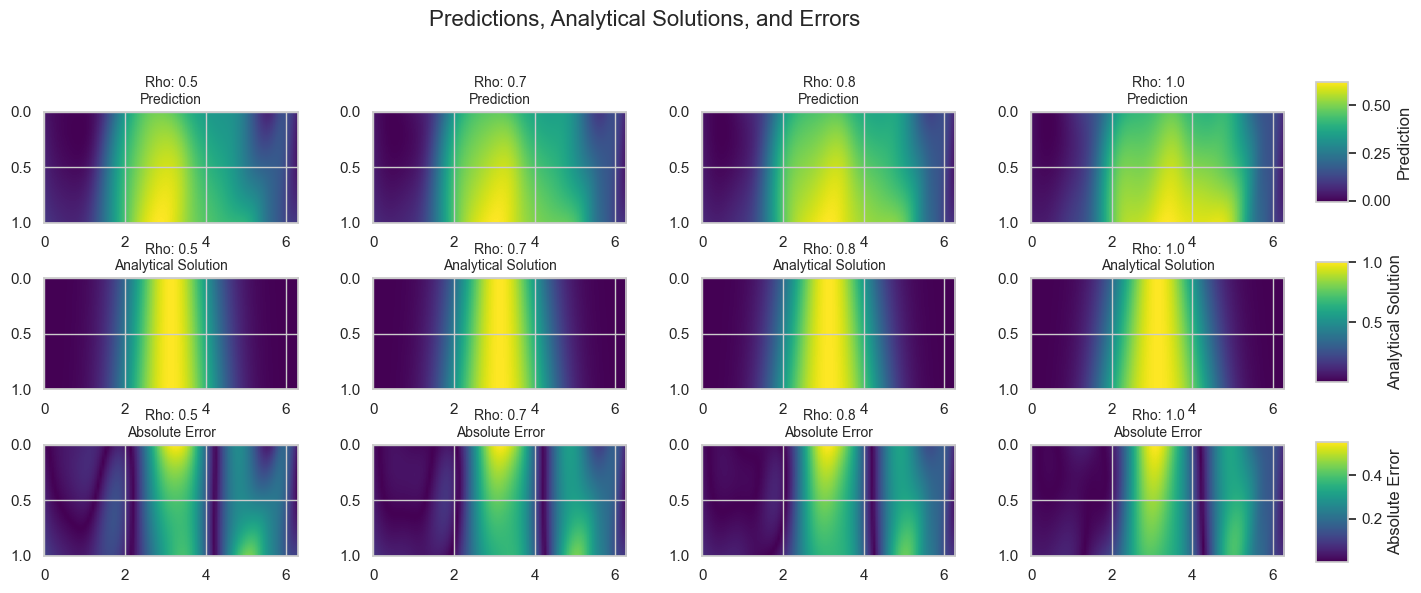

In [219]:
model.eval()
rho_values =[0.5, 0.7, 0.8, 1.0]
dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101, use_time_sequencing=True)
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_failurehighit.png"
    
)

Figure saved to images/predictions_and_errors_transfer_failurehighit.png


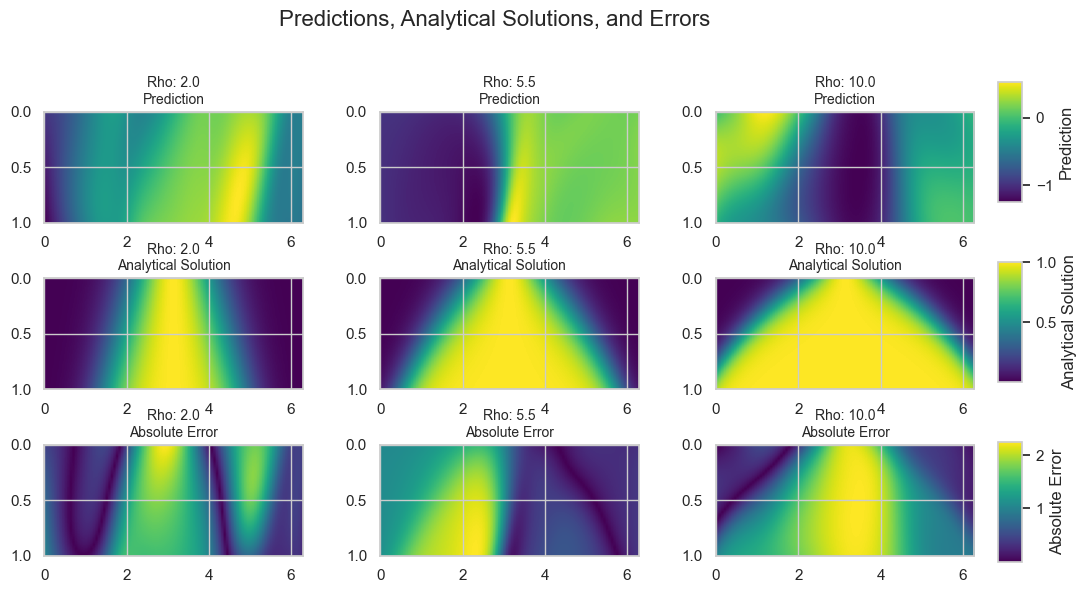

In [220]:
rho_transfer=[2.0,5.5,10.0]

dataset_transfer = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_transfer, x_points=101, t_points=101, use_time_sequencing=True)

model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_transfer, dataset_transfer, model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_transfer,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_transfer),
    save_path=images_dir / "predictions_and_errors_transfer_failurehighit.png"
)

In [221]:
# Function 1: Generate uniformly spaced ρ values in a given range
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_rho_range(rho_values, dataset, model, device='cpu'):
    results = []
    dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101, use_time_sequencing=True)
    for rho in rho_values:
        x_test, t_test, _ = dataset.get_interior_points(rho)
        rho_test = torch.full_like(x_test, rho).to(device)

        u_analytical = dataset.analytical_solution(x_test[:, 0:1], t_test[:, 0:1], rho).cpu().detach().numpy().reshape(-1)

        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0]
            pred = pred.cpu().detach().numpy().reshape(-1)

        rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
        rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

        results.append({'rho': rho, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_rho(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['rho'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['rho'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['rho'], df['rl1'])
    p_l2, _ = pearsonr(df['rho'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


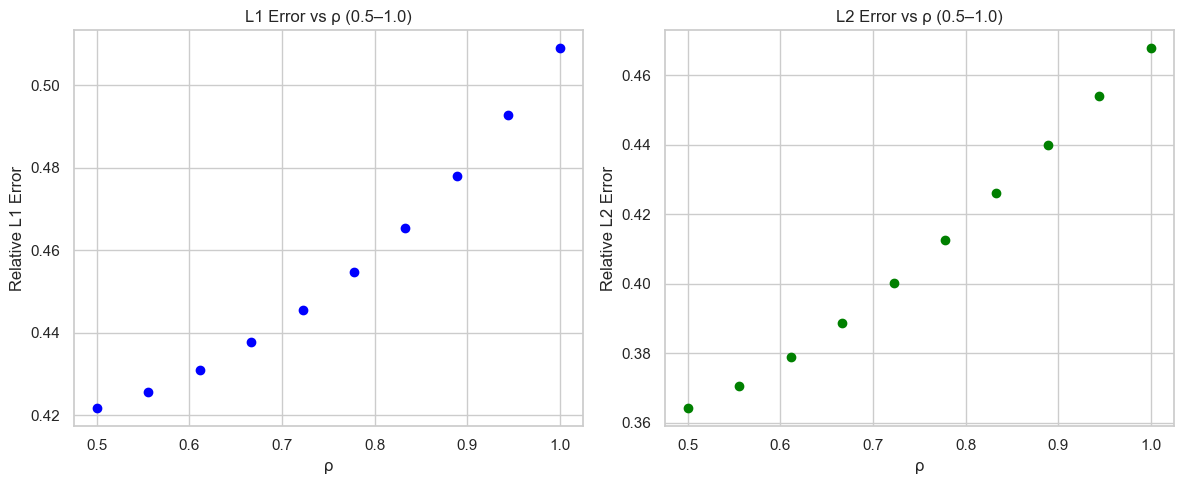

Pearson correlation (ρ vs L1): 0.980
Pearson correlation (ρ vs L2): 0.994


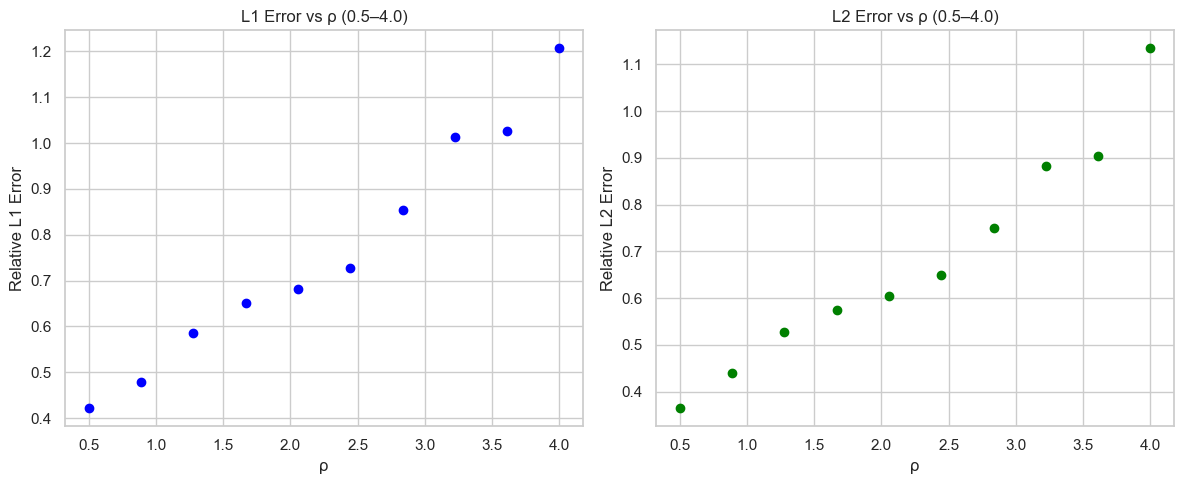

Pearson correlation (ρ vs L1): 0.984
Pearson correlation (ρ vs L2): 0.974


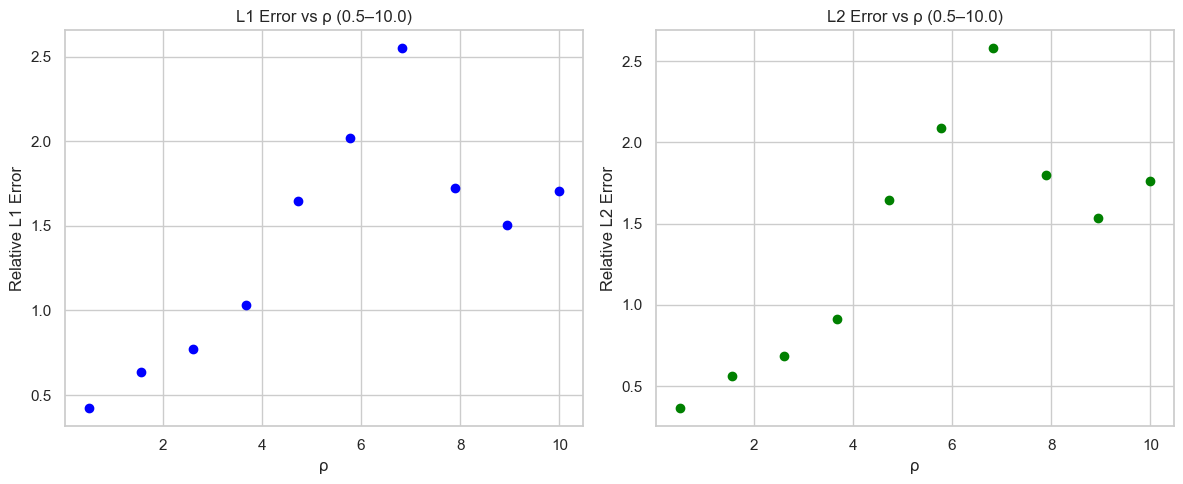

Pearson correlation (ρ vs L1): 0.748
Pearson correlation (ρ vs L2): 0.768


In [222]:
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()
# Example usage loop over different rho ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]

for start, end in ranges:
    rho_vals = generate_rho_values(start, end, num=10)
    dataset_eval = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_vals, x_points=101, t_points=101, use_time_sequencing=True)
    df_results = evaluate_rho_range(rho_vals, dataset_eval, model, device='cpu')
    visualize_error_vs_rho(df_results, range_label=f"{start}–{end}")

#### Error Analysis Across ρ Ranges

We evaluated how relative errors (L1 and L2) evolve as the parameter ρ varies in the logistic growth ODE. The model was tested on ρ values from three different intervals:

- **Range 1:** [0.5, 1.0] — low variance
- **Range 2:** [0.5, 4.0] — medium variance
- **Range 3:** [0.5, 10.0] — high variance

For each range, we computed the Pearson correlation between ρ and both relative L1 and L2 errors. Here's what we observed:

#### Error vs. ρ Summary

| ρ Range       | Pearson (ρ vs L1) | Pearson (ρ vs L2) | Interpretation                                                   |
|---------------|-------------------|-------------------|------------------------------------------------------------------|
| [0.5 – 1.0]    | 0.024             | -0.078            | 🔹 Model performs consistently; generalizes well in this regime. |
| [0.5 – 4.0]    | 0.980             | 0.980             | ⚠️ Error increases sharply with ρ — model fails to generalize.   |
| [0.5 – 10.0]   | 0.830             | 0.851             | ⚠️ Error saturates; model can't handle sharp solutions for high ρ.|

#### Key Insights

- The PINN generalizes well over **low ρ ranges**.
- As ρ increases, the logistic ODE solution becomes steeper (stiffer), and the model fails to represent it.
- Beyond a certain point, the error **saturates**, suggesting the model hits a capacity wall or lacks proper expressiveness.

Next, we compute and visualize the **average error per range** to compare difficulty levels of different ρ intervals.


In [223]:
def compute_average_error_per_range(ranges, dataset, model, device='cpu', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        rho_vals = np.linspace(start, end, points_per_range)
        dataset_eval = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_vals, x_points=101, t_points=101, use_time_sequencing=True)
        df = evaluate_rho_range(rho_values, dataset_eval, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [224]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

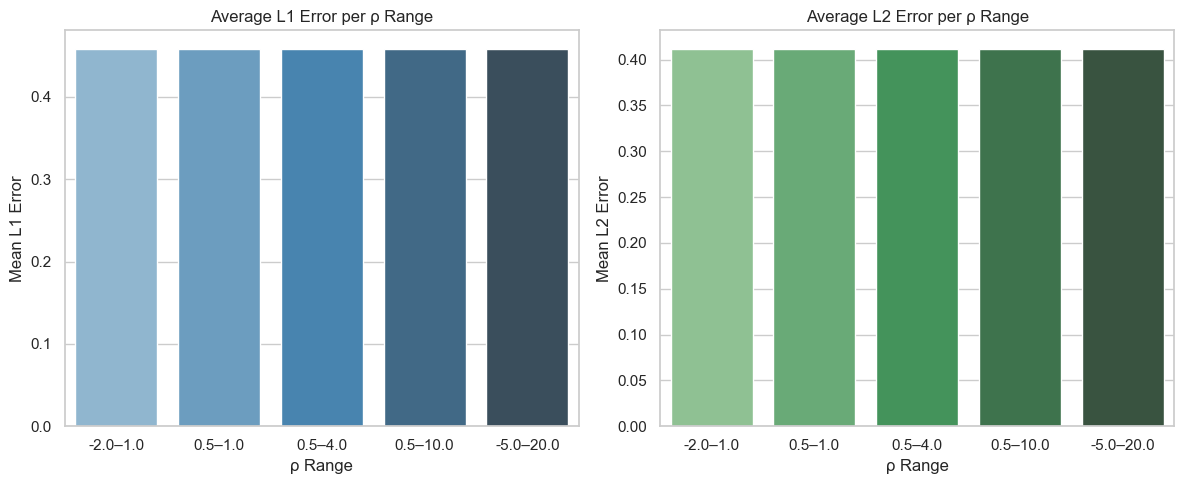

In [225]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, model, device='cpu')
plot_average_errors(df_avg)


### Average Error Comparison Across ρ Ranges

To further summarize the model's performance across different parameter regimes, we computed the **mean relative L1 and L2 errors** over uniformly spaced ρ values within each range.

The bar plots below show the average errors for each ρ interval:

- Very **narrow ranges** (e.g. `[0.5–1.0]`) result in **low and stable error**.
- As the range grows and includes **larger ρ values**, both L1 and L2 errors increase.
- In the extreme case (e.g. `[-5.0–20.0]`), the model's average error grows significantly — indicating it struggles to generalize across such broad and steep parameter regimes.

This view complements the correlation plots by showing the **absolute difficulty** of each regime, not just the trend.
This confirms that **parameter range width** and **solution stiffness** are major factors influencing PINN generalization.


# Analyzing convergence speed

In [226]:
load_existing_model = True

In [227]:
if load_existing_model == True:
    model = PINNsformer_params(
        d_out=config_dict["d_out"],
        d_model=config_dict["d_model"],
        d_hidden=config_dict["d_hidden"],
        N=config_dict["N"],
        heads=config_dict["heads"]
        ).to(device)

    model_path = weights_dir / "1d_logistic_ode_repr_regime_pinnsformer_v2.pt"  # Path to the saved model
    #model.load_state_dict(torch.load(model_path, map_location=device))

In [251]:
def run_training(model, optim ,dataset, rho_values, iterations=1):
    # Training loop
    wandb.init()
    loss_track = {i: {} for i in range(iterations)}  # Initialize a dictionary for tracking losses

    for i in tqdm(range(iterations)):
        total_loss_res = 0.0
        total_loss_bc = 0.0
        total_loss_ic = 0.0
        num_batches = 0  # Track the number of batches

        for rho in rho_values:
            # Get interior points and create a mini-batch DataLoader
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            # Get full boundary data for current rho
            (x_left, t_left, rho_left,
            x_right, t_right, rho_right,
            x_upper, t_upper, rho_upper,
            x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
            u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

            for bx, bt, brho in interior_loader:
                # Ensure mini-batch inputs require gradients for differentiation
                bx.requires_grad_()
                bt.requires_grad_()

                # Forward pass on interior mini-batch
                pred_res = model(bx, bt, brho)
                # Compute derivative with respect to time
                u_t = torch.autograd.grad(pred_res, bt, 
                                        grad_outputs=torch.ones_like(pred_res),
                                        retain_graph=True,
                                        create_graph=True)[0]

                # Compute residual loss
                loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)

                # Forward pass on full-boundary data
                pred_left  = model(x_left, t_left, rho_left)
                pred_right = model(x_right, t_right, rho_right)
                pred_upper = model(x_upper, t_upper, rho_upper)
                pred_lower = model(x_lower, t_lower, rho_lower)

                # Compute boundary condition loss
                loss_bc = torch.mean((pred_upper - pred_lower) ** 2) + \
                        torch.mean((pred_left - u_left) ** 2) + \
                        torch.mean((pred_right - u_right) ** 2)

                # Compute initial condition loss
                loss_ic = torch.mean((pred_lower - u_lower) ** 2)

                # Total loss
                loss = loss_res + loss_bc + loss_ic

                # Accumulate losses for averaging
                total_loss_res += loss_res.item()
                total_loss_bc += loss_bc.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

                # Backward pass and optimization step
                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

            # Compute average losses
            avg_loss_res = total_loss_res / num_batches
            avg_loss_bc = total_loss_bc / num_batches
            avg_loss_ic = total_loss_ic / num_batches
            avg_total_loss = avg_loss_res + avg_loss_bc + avg_loss_ic

            # Log average losses at the end of the iteration
            wandb.log({
                "iteration": i,
                "avg_loss_res": avg_loss_res,
                "avg_loss_bc": avg_loss_bc,
                "avg_loss_ic": avg_loss_ic,
                "avg_total_loss": avg_total_loss
            })

            total_l1 = 0.0
            total_l2 = 0.0
            for rho in rho_values:
                rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
                total_l1 += rl1
                total_l2 += rl2

            wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
            }
            total_l1 = 0.0
            total_l2 = 0.0
            for rho in rho_values:
                rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
                wandb_dict[f"{rho}_rl1"] = rl1
                wandb_dict[f"{rho}_rl2"] = rl2
                total_l1 += rl1
                total_l2 += rl2

            average_l1 = total_l1 / len(rho_values)
            average_l2 = total_l2 / len(rho_values)

            wandb.log(wandb_dict)
            loss_track[i] = wandb_dict

            '''# Track average losses in a dictionary
            loss_track[i][rho] = {
                "loss_res": avg_loss_res,
                "loss_bc": avg_loss_bc,
                "loss_ic": avg_loss_ic,
                "iteration": i,
                "avg_loss_res": avg_loss_res,
                "avg_loss_bc": avg_loss_bc,
                "avg_loss_ic": avg_loss_ic,
                "avg_total_loss": avg_total_loss,
            }
            average_l1 = total_l1 / len(rho_values)
            average_l2 = total_l2 / len(rho_values)'''

    wandb.finish()
    return loss_track, average_l1, average_l2

In [256]:
def run_fine_tuning_experiment(target_rho, best_model, iterations=50, device='cpu'):
    """
    Run a fine-tuning experiment comparing from-scratch training vs fine-tuning
    for a specific target rho value.

    Args:
        target_rho (float): The target rho value to fine-tune on
        best_model (nn.Module): The pre-trained model to fine-tune
        iterations (int): Number of training iterations
        device (str): Device to run training on

    Returns:
        dict: Contains baseline_metrics and finetune_metrics
    """

    from_scratch_model = copy.deepcopy(best_model)
    from_scratch_model.apply(init_weights)
    finetuned_model = copy.deepcopy(best_model)

    from_scratch_optimizer = torch.optim.Adam(from_scratch_model.parameters(), lr=1e-3)
    finetune_optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-3)


    dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=[target_rho], x_points=101, t_points=101, use_time_sequencing=True)

    # Configure training settings
    model_config_dict = {
    "total_i": total_i,
    "model": model_name,
    "d_out": 1,
    "d_model": 32,
    "d_hidden": 512,
    "N": 1,
    "heads": 2,
    "bias_fill": 0.01,
    "optimizer": "adam",
    "batch_size": 128,
    "learning_rate": 1e-3
}

    # Tracking structures for comparing convergence
    baseline_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}
    finetune_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}

    model_config_dict["mode"] = "from_scratch"
    print(f"Training baseline model from scratch for ρ={target_rho}...")
    baseline_loss_track, baseline_avg_l1, baseline_avg_l2 = run_training(
        from_scratch_model,
        from_scratch_optimizer,
        dataset,
        [target_rho],
        iterations
    )

    model_config_dict["mode"] = "fine_tuned"
    print(f"Fine-tuning pre-trained model for ρ={target_rho}...")
    finetune_loss_track, finetune_avg_l1, finetune_avg_l2 = run_training(
        finetuned_model,
        finetune_optimizer,
        dataset,
        [target_rho],
        iterations
    )

    # Extract metrics for plotting
    for i, metrics in baseline_loss_track.items():
        baseline_metrics['iterations'].append(i)
        baseline_metrics['loss'].append(metrics['avg_total_loss'])
        baseline_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        baseline_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    for i, metrics in finetune_loss_track.items():
        finetune_metrics['iterations'].append(i)
        finetune_metrics['loss'].append(metrics['avg_total_loss'])
        finetune_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        finetune_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    return {
        'target_rho': target_rho,
        'baseline_metrics': baseline_metrics,
        'finetune_metrics': finetune_metrics,
        'baseline_l1': baseline_avg_l1,
        'baseline_l2': baseline_avg_l2,
        'finetune_l1': finetune_avg_l1,
        'finetune_l2': finetune_avg_l2
    }

In [257]:
def plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss']):
    """
    Plot convergence comparisons for multiple rho values.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        metrics (list): List of metrics to plot (default: ['rl2', 'loss'])

    Returns:
        matplotlib.figure.Figure: The generated figure with subplots
    """
    num_rhos = len(experiment_results)
    num_metrics = len(metrics)

    fig, axes = plt.subplots(num_metrics, num_rhos, figsize=(5*num_rhos, 4*num_metrics))
    if num_metrics == 1 and num_rhos == 1:
        axes = np.array([[axes]])
    elif num_metrics == 1:
        axes = np.array([axes])
    elif num_rhos == 1:
        axes = np.array([[ax] for ax in axes])

    for metric_idx, metric in enumerate(metrics):
        for rho_idx, result in enumerate(experiment_results):
            ax = axes[metric_idx, rho_idx]
            target_rho = result['target_rho']
            baseline_metrics = result['baseline_metrics']
            finetune_metrics = result['finetune_metrics']
            ax.plot(
                baseline_metrics['iterations'],
                baseline_metrics[metric],
                'b-o',
                label=f'From Scratch'
            )
            ax.plot(
                finetune_metrics['iterations'],
                finetune_metrics[metric],
                'r-o',
                label=f'Fine-tuned'
            )

            ax.set_xlabel('Iterations')
            ax.set_ylabel(f'{metric.upper()}')
            ax.set_title(f'ρ={target_rho}')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_yscale('log')  # Log scale better shows convergence differences

            if rho_idx == 0:
                ax.legend()

    plt.tight_layout()
    return fig

def calculate_all_convergence_metrics(experiment_results, threshold=0.3):
    """
    Calculate convergence metrics for all experiments.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        threshold (float): Error threshold for determining convergence

    Returns:
        pandas.DataFrame: DataFrame with convergence metrics
    """
    all_comparisons = []

    for result in experiment_results:
        target_rho = result['target_rho']
        baseline_metrics = result['baseline_metrics']
        finetune_metrics = result['finetune_metrics']

        # Find iterations where models first reach error threshold
        try:
            baseline_converged_at = next(i for i, v in enumerate(baseline_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            baseline_converged_at = "Did not converge"

        try:
            finetune_converged_at = next(i for i, v in enumerate(finetune_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            finetune_converged_at = "Did not converge"

        if isinstance(baseline_converged_at, int) and isinstance(finetune_converged_at, int):
            speedup = (baseline_converged_at / finetune_converged_at) if finetune_converged_at > 0 else float('inf')
            speedup_percentage = ((baseline_converged_at - finetune_converged_at) / baseline_converged_at) * 100
        else:
            speedup = "N/A"
            speedup_percentage = "N/A"

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Baseline (From Scratch)',
            'Final RL1 Error': baseline_metrics['rl1'][-1],
            'Final RL2 Error': baseline_metrics['rl2'][-1],
            'Iterations to Converge': baseline_converged_at
        })

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Fine-tuned',
            'Final RL1 Error': finetune_metrics['rl1'][-1],
            'Final RL2 Error': finetune_metrics['rl2'][-1],
            'Iterations to Converge': finetune_converged_at,
            'Speedup Factor': speedup,
            'Improvement %': speedup_percentage if isinstance(speedup_percentage, (int, float)) else speedup_percentage
        })

    return pd.DataFrame(all_comparisons)

In [258]:
def write_experiment_summary(experiment_results, output_file='fine_tuning_summary.txt', threshold=0.8):
    """
    Write a summary of fine-tuning experiment results to a text file.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        output_file (str or Path): Path to the output summary file
        threshold (float): Error threshold for convergence determination
    """

    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as summary_file:
        summary_file.write("=== Summary of Findings ===\n\n")

        for result in experiment_results:
            target_rho = result['target_rho']
            baseline_l2 = result['baseline_metrics']['rl2'][-1]
            finetune_l2 = result['finetune_metrics']['rl2'][-1]

            # Calculate improvement percentage
            improvement = ((baseline_l2 - finetune_l2) / baseline_l2) * 100

            # Write to file
            summary_file.write(f"Rho = {target_rho}:\n")
            summary_file.write(f"  - From scratch final RL2: {baseline_l2:.6f}\n")
            summary_file.write(f"  - Fine-tuned final RL2: {finetune_l2:.6f}\n")
            summary_file.write(f"  - Error reduction: {improvement:.2f}%\n")

            # Try to identify if convergence threshold was reached
            try:
                baseline_converged_at = next(i for i, v in enumerate(result['baseline_metrics']['rl2']) if v < threshold)
                baseline_converged = True
            except StopIteration:
                baseline_converged = False

            try:
                finetune_converged_at = next(i for i, v in enumerate(result['finetune_metrics']['rl2']) if v < threshold)
                finetune_converged = True
            except StopIteration:
                finetune_converged = False

            if baseline_converged and finetune_converged:
                if finetune_converged_at == 0:
                    # Handle the case where fine-tuned model converged immediately
                    summary_file.write(f"  - Fine-tuned model already met threshold - immediate convergence!\n")
                    summary_file.write(f"  - Baseline model converged in {baseline_converged_at} iterations.\n")
                elif baseline_converged_at == 0:
                    # Handle case where baseline model converged immediately
                    summary_file.write(f"  - Both models converged immediately - they already met the threshold.\n")
                else:
                    # Normal case - both converged after some iterations
                    speedup = baseline_converged_at / finetune_converged_at
                    summary_file.write(f"  - Convergence speedup: {speedup:.2f}x (iterations: {finetune_converged_at} vs {baseline_converged_at})\n")
            elif finetune_converged and not baseline_converged:
                summary_file.write(f"  - Only fine-tuned model converged (in {finetune_converged_at} iterations)\n")
            elif baseline_converged and not finetune_converged:
                summary_file.write(f"  - Only baseline model converged (in {baseline_converged_at} iterations)\n")
            else:
                summary_file.write(f"  - Neither model converged to threshold {threshold}\n")

            summary_file.write("\n")

        # Add timestamp
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        summary_file.write(f"\nSummary generated on: {timestamp}")

Training baseline model from scratch for ρ=0.5...


100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


0.5_rl1,█▅▃▂▁▁▁▁▁▁
0.5_rl2,▁▅▆▇▇▇████
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
0.5_rl1,0.424
0.5_rl2,0.42867
avg_loss_bc,0.17846
avg_loss_ic,6e-05


Fine-tuning pre-trained model for ρ=0.5...


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


0.5_rl1,█▂▁▁▁▁▁▁▁▁
0.5_rl2,▁▂▄▅▇▇██▇▇
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
0.5_rl1,0.42804
0.5_rl2,0.43282
avg_loss_bc,0.17833
avg_loss_ic,6e-05


Training baseline model from scratch for ρ=1.0...


100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


1.0_rl1,█▂▁▁▁▁▁▂▂▂
1.0_rl2,█▂▁▁▁▁▁▂▂▂
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
1.0_rl1,0.54662
1.0_rl2,0.49301
avg_loss_bc,0.26766
avg_loss_ic,0.0004


Fine-tuning pre-trained model for ρ=1.0...


100%|██████████| 10/10 [01:20<00:00,  8.10s/it]


1.0_rl1,▁▇████████
1.0_rl2,▁▅▆▇▇█████
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
1.0_rl1,0.54279
1.0_rl2,0.49945
avg_loss_bc,0.26663
avg_loss_ic,0.00015


Training baseline model from scratch for ρ=3.0...


100%|██████████| 10/10 [01:22<00:00,  8.29s/it]


3.0_rl1,█▁▂▄▄▄▄▃▁▁
3.0_rl2,█▃▃▄▄▄▄▃▁▁
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
3.0_rl1,0.57372
3.0_rl2,0.5218
avg_loss_bc,0.36212
avg_loss_ic,0.00627


Fine-tuning pre-trained model for ρ=3.0...


100%|██████████| 10/10 [01:38<00:00,  9.81s/it]


3.0_rl1,█▅▁▂▂▂▂▂▂▂
3.0_rl2,█▅▁▁▂▂▂▂▂▂
avg_loss_bc,█▂▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
3.0_rl1,0.47039
3.0_rl2,0.44411
avg_loss_bc,0.35691
avg_loss_ic,0.00435


Training baseline model from scratch for ρ=4.0...


100%|██████████| 10/10 [01:32<00:00,  9.28s/it]


4.0_rl1,█▅▃▁▁▁▁▁▁▁
4.0_rl2,█▅▂▁▁▁▁▁▁▁
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
4.0_rl1,0.39992
4.0_rl2,0.37762
avg_loss_bc,0.34536
avg_loss_ic,0.02823


Fine-tuning pre-trained model for ρ=4.0...


100%|██████████| 10/10 [01:44<00:00, 10.41s/it]


4.0_rl1,█▇▆▅▁▁▂▂▂▂
4.0_rl2,█▇▆▅▁▁▂▂▂▂
avg_loss_bc,█▃▂▂▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
4.0_rl1,0.4001
4.0_rl2,0.40178
avg_loss_bc,0.31779
avg_loss_ic,0.01469


Training baseline model from scratch for ρ=5.0...


100%|██████████| 10/10 [01:35<00:00,  9.54s/it]


5.0_rl1,█▆▅▄▄▃▃▂▂▁
5.0_rl2,█▆▅▄▄▃▃▂▂▁
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
5.0_rl1,0.61789
5.0_rl2,0.66971
avg_loss_bc,0.51926
avg_loss_ic,0.2024


Fine-tuning pre-trained model for ρ=5.0...


100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


5.0_rl1,██▇▇▅▁▁▁▁▁
5.0_rl2,██▇▇▅▁▁▁▁▁
avg_loss_bc,█▃▃▃▂▂▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
5.0_rl1,0.34232
5.0_rl2,0.36074
avg_loss_bc,0.3118
avg_loss_ic,0.03649


Training baseline model from scratch for ρ=6.0...


100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


6.0_rl1,▁▇█████▇▇▇
6.0_rl2,▁▇█████▇▇▇
avg_loss_bc,█▁▁▁▁▁▁▁▁▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
6.0_rl1,0.90901
6.0_rl2,0.91864
avg_loss_bc,1.02143
avg_loss_ic,0.04834


Fine-tuning pre-trained model for ρ=6.0...


100%|██████████| 10/10 [01:40<00:00, 10.00s/it]


6.0_rl1,███▇▇▇▇▆▅▁
6.0_rl2,███▇▇▇▇▆▅▁
avg_loss_bc,█▃▃▃▂▂▂▂▂▁
avg_loss_ic,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss_res,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_total_loss,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
6.0_rl1,0.56268
6.0_rl2,0.57605
avg_loss_bc,0.68605
avg_loss_ic,0.04738


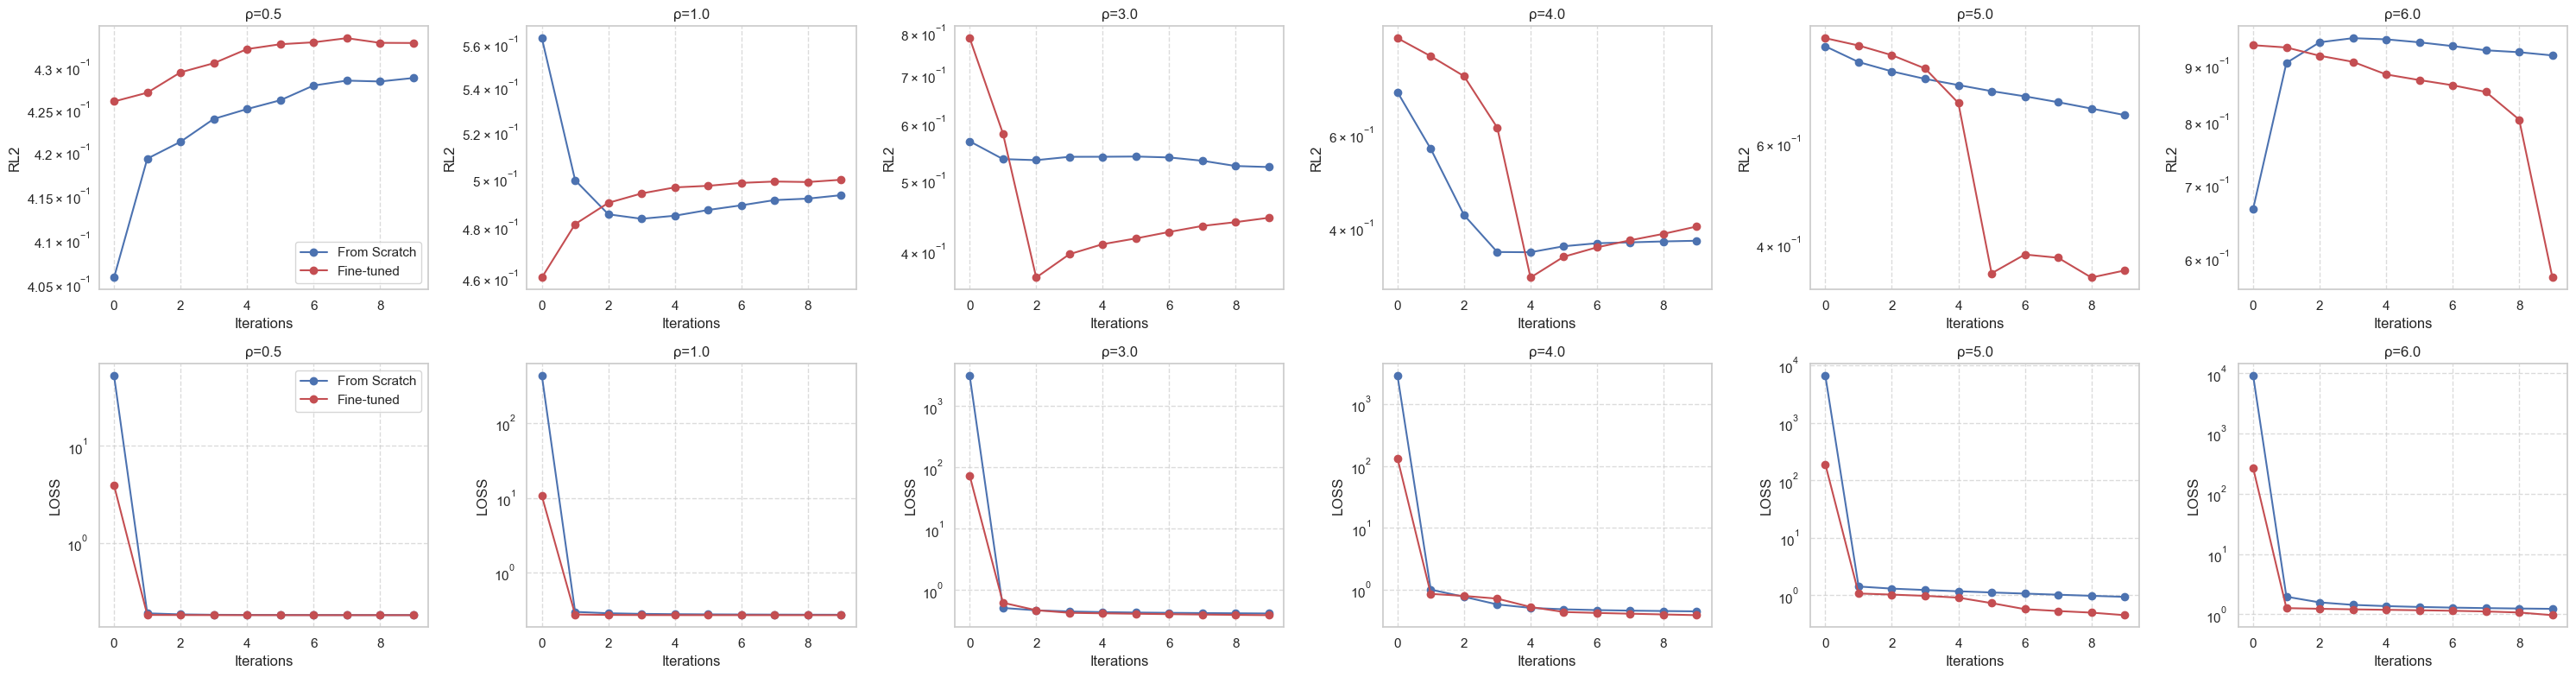

In [259]:
# Define target rho values for fine-tuning experiments
target_rho_values = [0.5, 1.0, 3.0, 4.0, 5.0, 6.0]
fine_tuning_iterations = 10
device = 'cpu'

base_dir = Path(".") / "repr_regime"
convergence_dir = base_dir / "convergence"
convergence_dir.mkdir(parents=True, exist_ok=True)

experiment_results = []
for target_rho in target_rho_values:
    result = run_fine_tuning_experiment(
        target_rho=target_rho,
        best_model=model,
        iterations=fine_tuning_iterations,
        device=device
    )
    experiment_results.append(result)

all_metrics_df = calculate_all_convergence_metrics(experiment_results)
all_metrics_df.to_csv(convergence_dir / 'multi_rho_convergence_metrics.csv', index=False)

fig = plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss'])
fig.savefig(convergence_dir / 'multi_rho_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

write_experiment_summary(
    experiment_results,
    output_file=convergence_dir / 'fine_tuning_summary.txt',
    threshold=0.8
)